In [5]:
import warnings
warnings.filterwarnings('ignore')

!pip install --quiet xgboost lightgbm imbalanced-learn shap networkx seaborn numba

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

import shap
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cosine

import os

plt.style.use('default')
sns.set_palette("deep")
np.random.seed(42)

In [6]:
def stratified_explanation_sample(X_te, y_te, n=30, random_state=42, min_pos=5):
    """
    Stratified sampling for explanation methods.
    Ensures at least 'min_pos' default cases (if available),
    which is critical for highly imbalanced datasets (e.g., 1% default).

    Parameters
    ----------
    X_te : pd.DataFrame
        Test features for the fold.
    y_te : pd.Series or array
        Corresponding test labels.
    n : int
        Total number of samples to return.
    min_pos : int
        Minimum number of positive (default=1) samples to include.

    Returns
    -------
    pd.DataFrame
        Stratified sample of size <= n.
    """

    # Ensure consistent indexing
    X_te = X_te.reset_index(drop=True)
    y_te = pd.Series(y_te).reset_index(drop=True)

    n = min(n, len(X_te))

    # Indices for positive and negative classes
    pos_idx = y_te[y_te == 1].index
    neg_idx = y_te[y_te == 0].index

    # Number of positives to include
    n_pos = min(min_pos, len(pos_idx), n)
    n_neg = n - n_pos

    # Sample positives and negatives
    X_pos = X_te.loc[pos_idx].sample(n=n_pos, random_state=random_state) if n_pos > 0 else X_te.iloc[0:0]
    X_neg = X_te.loc[neg_idx].sample(n=n_neg, random_state=random_state) if n_neg > 0 else X_te.iloc[0:0]

    # Combine and shuffle
    X_sample = pd.concat([X_pos, X_neg]).sample(frac=1, random_state=random_state)

    return X_sample

Positive = the event of interest

In credit scoring, the “event” is default

So default = 1 is the positive class

In the Coursera Loan Default dataset, the positive class corresponds to default events (label = 1), which represent only ~1% of the data. To ensure meaningful explanations, we implemented a stratified sampling strategy that guarantees at least five positive cases in every explanation subset. This prevents degenerate explanations and ensures that all interpretability metrics are computed on balanced, informative samples.

✓ CSV loaded: (227973, 18)
       LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0  AWSBW843Q1   56   62996      117825          486              90   
1  OZKH1K1SKG   26  102924       86556          464             101   
2  TG22V9PWEG   48   71536      249742          444              77   
3  XHY1QSXPXG   57  145307      180646          510              25   
4  KNUOG8Q45R   35   72117      229909          435             104   

   NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
0               2         23.04        12      0.19     Master's   
1               3          3.41        60      0.63          PhD   
2               1          9.39        60      0.75          PhD   
3               3         15.52        24      0.87  High School   
4               3          9.49        24      0.76          PhD   

  EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose  \
0  Self-employed      Divorced          No           Yes    Busin

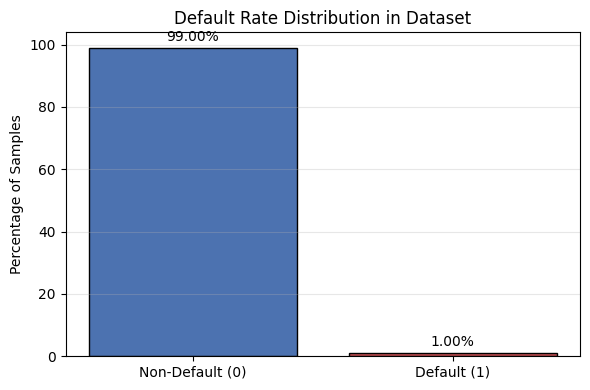

In [7]:
# ============================================================
#  LOAD DATA + DEFAULT DISTRIBUTION PLOT
# ============================================================

df = pd.read_csv('/content/Loan_Coursera_1%.csv')
print("✓ CSV loaded:", df.shape)
print(df.head())
print(df.info())

# ------------------------------------------------------------
# DEFAULT RATE DISTRIBUTION
# ------------------------------------------------------------
# Calculate default percentage
default_counts = df['Default'].value_counts().sort_index()
default_pct = default_counts / len(df) * 100

print("\nDefault distribution:")
print(default_counts)
print(default_pct.round(2))

# Plot default distribution
plt.figure(figsize=(6, 4))
bars = plt.bar(
    ['Non‑Default (0)', 'Default (1)'],
    default_pct.values,
    color=['#4C72B0', '#C44E52'],
    edgecolor='black'
)

plt.bar_label(bars, fmt="%.2f%%", padding=3)
plt.ylabel("Percentage of Samples")
plt.title("Default Rate Distribution in Dataset")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# ============================================================
#  PREPROCESSING
# ============================================================

# Drop ID
df = df.drop(columns=['LoanID'])

# Target and features
y = df['Default']
X = df.drop(columns=['Default'])

# Categorical features
categorical_features = [
    'Education',
    'EmploymentType',
    'MaritalStatus',
    'HasMortgage',
    'HasDependents',
    'LoanPurpose',
    'HasCoSigner'
]

# Ensure categorical as string
for col in categorical_features:
    X[col] = X[col].astype(str)

# Numeric features
numeric_features = [
    'Age',
    'Income',
    'LoanAmount',
    'CreditScore',
    'MonthsEmployed',
    'NumCreditLines',
    'InterestRate',
    'LoanTerm',
    'DTIRatio'
]

# Explicit OHE categories for reproducibility
cat_categories = [sorted(X[col].unique()) for col in categorical_features]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False, categories=cat_categories), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

X_processed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
d = X_processed.shape[1]

print("Processed features:", d)


Processed features: 24


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# BLOCK : One-time Hyperparameter Tuning
# ──────────────────────────────────────────────────────────────────────────────

def tune_model(X, y, model_name="LGB", n_iter=15):
    print(f"\n=== Tuning {model_name} ===")

    numeric = X.select_dtypes(include=np.number).columns.tolist()
    cat     = X.select_dtypes(exclude=np.number).columns.tolist()

    prep = ColumnTransformer([
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat),
        ('num', StandardScaler(), numeric)
    ], remainder='passthrough')

    if model_name == "RF":
        base_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
        param_dist = {
            'clf__n_estimators':     [80, 120, 160, 200, 250],
            'clf__max_depth':        [5, 8, 11, 15, None],
            'clf__min_samples_split':[2, 5, 10],
            'clf__min_samples_leaf': [1, 2, 4],
            'clf__max_features':     ['sqrt', 'log2', 0.6],
            'clf__class_weight':     ['balanced', None]
        }

    elif model_name == "XGB":
        base_model = xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='auc', verbosity=0)
        param_dist = {
            'clf__n_estimators':     [80, 120, 180, 250],
            'clf__learning_rate':    [0.008, 0.02, 0.05, 0.12],
            'clf__max_depth':        [4, 6, 8, 10],
            'clf__subsample':        [0.65, 0.8, 0.95],
            'clf__colsample_bytree': [0.6, 0.8, 1.0],
            'clf__reg_lambda':       [0.1, 1, 5],
            'clf__scale_pos_weight': [1, 10, 30, 60]
        }

    elif model_name == "LGB":
        base_model = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
        param_dist = {
            'clf__n_estimators':     [80, 120, 180, 250],
            'clf__learning_rate':    [0.008, 0.02, 0.05, 0.12],
            'clf__max_depth':        [4, 6, 8, 10],
            'clf__num_leaves':       [20, 40, 80, 150],
            'clf__subsample':        [0.65, 0.8, 0.95],
            'clf__colsample_bytree': [0.6, 0.8, 1.0],
            'clf__reg_lambda':       [0.1, 1, 5],
            'clf__class_weight':     ['balanced', None]
        }

    pipe = Pipeline([('prep', prep), ('clf', base_model)])

    search = RandomizedSearchCV(
        pipe, param_distributions=param_dist,
        n_iter=n_iter,
        cv=StratifiedKFold(4, shuffle=True, random_state=RANDOM_STATE),
        scoring='roc_auc',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )

    # The key fix: pass y as clean numpy int array
    y_clean = y.values.astype(np.int64) if hasattr(y, 'values') else y.astype(np.int64)

    search.fit(X, y_clean)

    print(f"Best {model_name} AUC: {search.best_score_:.4f}")
    print("Best params:", search.best_params_)

    return search.best_estimator_, search.best_params_, search.best_score_


# ─── Usage (after loading df) ────────────────────────────────────────────────
# Make sure y is clean
y = df['Default'].astype(np.int64)   # or .values.astype(np.int64)

X_tune = df.drop(columns=['Default', 'LoanID'])  # drop ID too

best_rf, rf_params, rf_auc = tune_model(X_tune, y, "RF", n_iter=15)
best_xgb, xgb_params, xgb_auc = tune_model(X_tune, y, "XGB", n_iter=15)
best_lgb, lgb_params, lgb_auc = tune_model(X_tune, y, "LGB", n_iter=15)

print("\nBest parameters for thesis table:")
print("RF:", rf_params)
print("XGB:", xgb_params)
print("LGB:", lgb_params)


=== Tuning RF ===
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best RF AUC: 0.7363
Best params: {'clf__n_estimators': 120, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__max_depth': 5, 'clf__class_weight': 'balanced'}

=== Tuning XGB ===
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best XGB AUC: 0.7380
Best params: {'clf__subsample': 0.95, 'clf__scale_pos_weight': 30, 'clf__reg_lambda': 5, 'clf__n_estimators': 120, 'clf__max_depth': 6, 'clf__learning_rate': 0.02, 'clf__colsample_bytree': 0.8}

=== Tuning LGB ===
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best LGB AUC: 0.7370
Best params: {'clf__subsample': 0.8, 'clf__reg_lambda': 5, 'clf__num_leaves': 150, 'clf__n_estimators': 120, 'clf__max_depth': 8, 'clf__learning_rate': 0.008, 'clf__colsample_bytree': 0.6, 'clf__class_weight': None}

Best parameters for thesis table:
RF: {'clf__n_estimators': 120, 'clf__min_samples_split': 2, 'clf__min_s

Randomized cv was performed and the output is entered as parameters

In [9]:
# ============================================================
#  MODELS (BEST PARAMETER CONFIGURATION)
# ============================================================

BEST_PARAMS = {
    'RF': {
        'n_estimators': 120,
        'min_samples_split': 2,
        'min_samples_leaf': 4,
        'max_features': 'log2',
        'max_depth': 5,
        'class_weight': 'balanced',
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    },
    'XGB': {
        'subsample': 0.95,
        'scale_pos_weight': 30,
        'reg_lambda': 5,
        'n_estimators': 120,
        'max_depth': 6,
        'learning_rate': 0.02,
        'colsample_bytree': 0.8,
        'random_state': RANDOM_STATE,
        'eval_metric': 'auc',
        'verbosity': 0
    },
    'LGB': {
        'subsample': 0.8,
        'reg_lambda': 5,
        'num_leaves': 150,
        'n_estimators': 120,
        'max_depth': 8,
        'learning_rate': 0.008,
        'colsample_bytree': 0.6,
        'random_state': RANDOM_STATE,
        'verbose': -1
    }
}

models = {
    'RF': RandomForestClassifier(**BEST_PARAMS['RF']),
    'XGB': xgb.XGBClassifier(**BEST_PARAMS['XGB']),
    'LGB': lgb.LGBMClassifier(**BEST_PARAMS['LGB'])
}

print("\nBEST MODEL CONFIGURATION:")
for mname, m in models.items():
    print(f"\n[{mname}]")
    print(m.get_params())



BEST MODEL CONFIGURATION:

[RF]
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 120, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

[XGB]
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'auc', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.02, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max

In [10]:
resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'CostSensitive': 'cost'
}

# Class weights for cost-sensitive learning
class_weight_dict = {
    int(cls): float(w)
    for cls, w in zip(np.unique(y), compute_class_weight('balanced', classes=np.unique(y), y=y))
}

print("\nClass weights (for CostSensitive):", class_weight_dict)



Class weights (for CostSensitive): {0: 0.5050488714808546, 1: 50.01601579640193}


In [12]:
 #============================================================
# 4. DOMAIN GROUPS (BASEL‑ALIGNED)
# ============================================================

def build_domain_groups_coursera(fnames):
    """
    Build domain groups following Basel II/III credit‑risk categories.

    Grouping philosophy:
    --------------------
    1. ObligorCharacteristics  → Borrower demographic & socioeconomic profile
    2. Creditworthiness        → Historical credit behaviour & capacity
    3. ContractTerms           → Loan pricing & contractual structure
    4. CollateralSupport       → Guarantees, co-signers, mortgages
    5. LoanMetadata            → Purpose & administrative metadata
    """

    groups = {
        "ObligorCharacteristics": [],
        "Creditworthiness": [],
        "ContractTerms": [],
        "CollateralSupport": [],
        "LoanMetadata": []
    }

    for i, name in enumerate(fnames):
        lname = name.lower()

        # 1. Obligor Characteristics (Basel: borrower profile)
        if any(k in lname for k in [
            "age", "income", "education", "employmenttype",
            "maritalstatus", "hasdependents"
        ]):
            groups["ObligorCharacteristics"].append(i)

        # 2. Creditworthiness (Basel: credit history & behavioural indicators)
        elif any(k in lname for k in [
            "creditscore", "numcreditlines", "monthsemployed"
        ]):
            groups["Creditworthiness"].append(i)

        # 3. Contract Terms (Basel: loan structure & pricing)
        elif any(k in lname for k in [
            "loanamount", "interestrate", "loanterm", "dtiratio"
        ]):
            groups["ContractTerms"].append(i)

        # 4. Collateral & Support (Basel: guarantees, collateral)
        elif any(k in lname for k in [
            "hasmortgage", "hascosigner"
        ]):
            groups["CollateralSupport"].append(i)

        # 5. Loan Metadata (Basel: purpose, administrative)
        elif "loanpurpose" in lname:
            groups["LoanMetadata"].append(i)

    # Remove empty groups
    return {g: v for g, v in groups.items() if len(v) > 0}


# Build groups
domain_groups = build_domain_groups_coursera(feature_names)

print("Basel‑aligned domain groups:")
for g, feats in domain_groups.items():
    print(f"  {g}: {len(feats)} features")


Basel‑aligned domain groups:
  ObligorCharacteristics: 13 features
  Creditworthiness: 3 features
  ContractTerms: 4 features
  CollateralSupport: 1 features
  LoanMetadata: 3 features


In [13]:
# ============================================================
# 5. EXPLANATION METHODS
# ============================================================

def get_shap_reliable(pipe, X_test):
    """
    Compute SHAP values using TreeExplainer.
    - Sample size: we pass X_test as given by caller.
    - For main experiment: X_sample = min(30, len(X_test)).
    """
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        # Handle different SHAP output shapes
        if isinstance(sv, list):
            return sv[1]
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"  SHAP failed: {e}")
        n_features = X_proc.shape[1]
        return np.zeros((len(X_test), n_features))


def compute_banzhaf(pipe, X_test, n_samples=2, max_instances=2):
    """
    Approximate Banzhaf values via random coalitions.

    - We use at most 'max_instances' instances (default: 2).
    - For each feature f and each instance:
        * Draw 'n_samples' random coalitions (default: 2).
        * For each coalition, compute Δp = p1 - p0 where:
            p1 = P(y=1 | coalition with feature f active)
            p0 = P(y=1 | coalition with feature f set to 0)
        * Banzhaf(f) ≈ mean(Δp) over coalitions.

    This is intentionally very small for speed; it is illustrative.
    """
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                coal = np.random.binomial(1, 0.5, n_feat)
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]

                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]

                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat


def compute_myerson(pipe, X_test, G, alpha=0.5):
    """
    Myerson-style redistribution over a graph G using SHAP as base.

    - Step 1: compute SHAP values on X_test.
    - Step 2: average SHAP over instances → φ_SHAP.
    - Step 3: for each feature i:
        φ_Myerson(i) = (1 - α) * φ_SHAP(i) + α * mean(φ_SHAP(j) for j in N(i))

    We then tile φ_Myerson to match a small number of instances
    (here: min(30, len(X_test))) for consistency with other methods.
    """
    shap_vals = get_shap_reliable(pipe, X_test)
    shap_mean = shap_vals.mean(axis=0)
    d_local = len(shap_mean)
    phi = np.zeros(d_local)

    for i in range(d_local):
        neighbors = list(G.neighbors(i)) if i in G.nodes() else []
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors if j < d_local])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean

    return np.tile(phi, (min(30, len(X_test)), 1)), shap_vals, shap_mean


def build_data_groups(X_proc, n_groups=5):
    """
    Data-driven groups via correlation clustering.

    - Distance matrix: D_ij = 1 - |corr(i, j)|
    - Agglomerative clustering on D with 'average' linkage.
    """
    try:
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)
        corr = np.nan_to_num(corr, nan=0.0)
        np.fill_diagonal(corr, 1.0)
        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups, metric='precomputed', linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Data_Cluster_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"  Data-driven grouping failed: {e}")
        n_features = X_proc.shape[1]
        return {"Data_Default": list(range(n_features))}, np.eye(n_features)


def build_model_groups(shap_vals, n_groups=5):
    """
    Model-driven groups via correlation of SHAP patterns.

    - We compute corr over features (or instances, depending on shape),
      then cluster using the same distance D_ij = 1 - |corr(i, j)|.
    """
    try:
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)
        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()

        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            return {"Model_Default": list(range(n_features))}, np.eye(n_features)

        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)
        corr = np.nan_to_num(corr, nan=0.0)
        np.fill_diagonal(corr, 1.0)
        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups, metric='precomputed', linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Model_Group_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"  Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        return {"Model_Default": list(range(n_features))}, np.eye(n_features)


def owen_from_phi(phi, groups):
    """
    Owen-style redistribution within groups.

    For each group G:
        total_G = Σ_{i∈G} |φ_i|
        per_G   = total_G / |G|
        Owen_i  = sign(φ_i) * per_G

    This preserves total absolute importance within each group.
    """
    d_local = len(phi)
    out = np.zeros(d_local)

    for _, feats in groups.items():
        if len(feats) == 0:
            continue
        valid_feats = [f for f in feats if f < d_local]
        if not valid_feats:
            continue
        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)
        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per
    return out


def compute_Q(groups, dep):
    """
    Group quality Q:

        Q = mean(within-group dependency) / mean(across-group dependency)

    where 'dep' is a dependency matrix (e.g., |corr|).
    """
    try:
        d_local = dep.shape[0]
        group_id = np.full(d_local, -1)

        for gid, (_, feats) in enumerate(groups.items()):
            for f in feats:
                if f < d_local:
                    group_id[f] = gid

        within, across = [], []
        for i in range(d_local):
            for j in range(i+1, d_local):
                if group_id[i] == group_id[j] and group_id[i] != -1:
                    within.append(dep[i, j])
                elif group_id[i] != -1 and group_id[j] != -1:
                    across.append(dep[i, j])

        if len(within) == 0 or len(across) == 0:
            return np.nan

        within_mean = np.mean(within)
        across_mean = np.mean(across)

        if across_mean == 0:
            return np.nan

        return float(within_mean / across_mean)
    except:
        return np.nan


def adaptive_owen_myerson(phi_my):
    """
    R-Myerson (Redistributed Myerson):

    - Start from Myerson φ_Myerson.
    - Redistribute total absolute importance uniformly:

        total = Σ_i |φ_Myerson(i)|
        per   = total / d
        R-Myerson(i) = sign(φ_Myerson(i)) * per
    """
    d_local = len(phi_my)
    total = np.sum(np.abs(phi_my))
    if d_local == 0:
        return phi_my
    per = total / d_local
    out = np.zeros(d_local)
    for i in range(d_local):
        sign = np.sign(phi_my[i]) if phi_my[i] != 0 else 1
        out[i] = sign * per
    return out

print("✓ Explanation methods and group quality defined")
print("  SHAP sample size per fold: up to 30 test instances")
print("  Banzhaf: max_instances=2, n_samples=2 per feature")
print("  Myerson: tiled to min(30, |X_test|) instances")

✓ Explanation methods and group quality defined
  SHAP sample size per fold: up to 30 test instances
  Banzhaf: max_instances=2, n_samples=2 per feature
  Myerson: tiled to min(30, |X_test|) instances


In [14]:
# ============================================================
# 6. INTERPRETABILITY METRICS
# ============================================================

def stability_cv(expl_list):
    """
    Coefficient of variation (CV) of absolute explanations across folds.

    - For each feature j:
        mean_j = mean_folds(|e_j|)
        std_j  = std_folds(|e_j|)
        CV_j   = std_j / (mean_j + ε)

    - Stability = 1 - mean_j(CV_j)
    - Here we return CV; stability is computed as 1 - CV.
    """
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack([np.abs(e) for e in expl_list])
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0


def kuncheva_index(expl_list, k=10):
    """
    Kuncheva index for top-k feature set stability.

    - For each explanation matrix:
        * Compute mean absolute importance per feature.
        * Take top-k features → set S_i.
    - For each pair (S_i, S_j):

        KI = (|S_i ∩ S_j| - k^2/d) / (k - k^2/d)

    where d is the number of features.
    """
    if len(expl_list) < 2:
        return 0.0

    sets = []
    d_local = None
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            if d_local is None:
                d_local = len(imp)
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(set())

    if len(sets) < 2 or d_local is None:
        return 0.0

    ki_values = []
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d_local:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d_local) / (k - (k**2)/d_local)
            ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)

    return float(np.mean(ki_values)) if ki_values else 0.0


def cosine_directional_consistency(expl_list):
    """
    Cosine similarity of mean importance vectors across folds.

    - For each fold i:
        v_i = mean_instances(|e_i|)  (feature-wise)
    - Cosine similarity between all pairs (v_p, v_s) is averaged.
    """
    if len(expl_list) < 2:
        return 0.0

    mean_vecs = [np.mean(np.abs(e), axis=0).ravel() for e in expl_list]
    K = len(mean_vecs)
    cos_sims = []

    for p in range(K):
        for s in range(p + 1, K):
            v_p = mean_vecs[p]
            v_s = mean_vecs[s]
            cos_val = 1 - cosine(v_p, v_s)
            cos_sims.append(cos_val)

    if not cos_sims:
        return 0.0
    return np.mean(cos_sims)


def interpretability_score(cv, kuncheva, cosine_score, beta=1/3):
    """
    Interpretability score I:

        I = β * (1 - CV) + β * Kuncheva + β * Cosine

    where β = 1/3 so that all three components are equally weighted.
    """
    return beta * (1 - cv) + beta * kuncheva + beta * cosine_score


def normalize(s):
    """
    Min-max normalization:

        s_norm = (s - min(s)) / (max(s) - min(s) + ε)
    """
    return (s - s.min()) / (s.max() - s.min() + 1e-8)


def performance_interpretability_score(auc_series, I_series, alpha=0.5):
    """
    S(α): Performance–Interpretability score.

        S(α) = α * AUC_norm + (1 - α) * I_norm

    where:
        AUC_norm = normalized AUC
        I_norm   = normalized interpretability score
        α ∈ [0,1] controls the trade-off.
    """
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

print("✓ Interpretability metrics and S(α) defined")

✓ Interpretability metrics and S(α) defined


In [15]:
# ============================================================
# 7. MAIN EXPERIMENT
# ============================================================

print("\n" + "="*80)
print("RUNNING MAIN EXPERIMENT – 7 EXPLANATION METHODS -Kaggle Coursera Loan default dataset")
print("="*80)

# 4-fold CV
cv_folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
all_records = []

method_order = [
    'SHAP',
    'Banzhaf',
    'Myerson',
    'Owen-Domain',
    'Owen-Data',
    'Owen-Model',
    'R-Myerson'
]

total_configs = len(models) * len(resamplers)
config_count = 0

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        config_count += 1
        print(f"\n[{config_count}/{total_configs}] Model: {mname} | Sampler: {sname}")

        aucs = []

        shap_runs = []
        banzhaf_runs = []
        myerson_runs = []

        owen_dom_runs = []
        owen_data_runs = []
        owen_model_runs = []
        r_myerson_runs = []

        Q_dom_list = []
        Q_data_list = []
        Q_model_list = []

        for fold, (train_idx, test_idx) in enumerate(cv_folds.split(X, y), 1):
            print(f"  Fold {fold} / 4")
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            # Myerson graph (train-only)
            preproc_graph = clone(preprocessor)
            X_tr_proc = preproc_graph.fit_transform(X_tr)

            corr_tr_my = np.corrcoef(X_tr_proc.T)
            corr_tr_my = np.nan_to_num(corr_tr_my)

            G_myerson = nx.Graph()
            G_myerson.add_nodes_from(range(d))
            for i in range(d):
                for j in range(i + 1, d):
                    if abs(corr_tr_my[i, j]) >= 0.25:
                        G_myerson.add_edge(i, j)

            # Build pipeline
            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))

            clf_clone = clone(model)
            steps.append(('clf', clf_clone))
            pipe = ImbPipeline(steps)

            # Cost-sensitive configuration
            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0]
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr, y_tr)

            # Performance
            y_proba = pipe.predict_proba(X_te)[:, 1]
            auc = roc_auc_score(y_te, y_proba)
            aucs.append(auc)
            print(f"    AUC: {auc:.4f}")

            # Sample for explanations (small for speed)
            # SHAP sample size: up to 30 test instances

            X_sample = stratified_explanation_sample(X_te, y_te, n=30, random_state=42)
            fnames = preprocessor.get_feature_names_out()

            # SHAP
            shap_vals = get_shap_reliable(pipe, X_sample)
            shap_runs.append(shap_vals)

            # Banzhaf (max_instances=2, n_samples=2)
            banzhaf_vals = compute_banzhaf(pipe, X_sample, n_samples=2, max_instances=2)
            banzhaf_runs.append(banzhaf_vals)

            # Myerson
            myerson_vals, shap_full, shap_mean = compute_myerson(pipe, X_sample, G_myerson)
            myerson_runs.append(myerson_vals)

            # Data-driven groups
            data_groups, dep_data = build_data_groups(X_tr_proc, n_groups=5)

            # Model-driven groups (background SHAP on up to 200 train instances)
            bg_sample = X_tr.sample(n=min(200, len(X_tr)), random_state=42)
            shap_bg = get_shap_reliable(pipe, bg_sample)
            model_groups, dep_mod = build_model_groups(shap_bg, n_groups=5)

            # Correlation for domain Q
            corr_tr = np.abs(np.corrcoef(X_tr_proc.T))
            corr_tr = np.nan_to_num(corr_tr, nan=0.0)

            # Base SHAP mean
            phi_shap = shap_full.mean(axis=0)

            # Owen-Domain
            owen_dom_vec = owen_from_phi(phi_shap, domain_groups)
            owen_dom = np.tile(owen_dom_vec, (len(X_sample), 1))
            owen_dom_runs.append(owen_dom)
            Q_dom_list.append(compute_Q(domain_groups, corr_tr))

            # Owen-Data
            owen_data_vec = owen_from_phi(phi_shap, data_groups)
            owen_data = np.tile(owen_data_vec, (len(X_sample), 1))
            owen_data_runs.append(owen_data)
            Q_data_list.append(compute_Q(data_groups, dep_data))

            # Owen-Model
            owen_model_vec = owen_from_phi(phi_shap, model_groups)
            owen_model = np.tile(owen_model_vec, (len(X_sample), 1))
            owen_model_runs.append(owen_model)
            Q_model_list.append(compute_Q(model_groups, dep_mod))

            # R-Myerson (Redistributed Myerson)
            phi_my = myerson_vals.mean(axis=0)
            r_my_vec = adaptive_owen_myerson(phi_my)
            r_myerson = np.tile(r_my_vec, (len(X_sample), 1))
            r_myerson_runs.append(r_myerson)

        auc_mean = np.mean(aucs)
        print(f"  → Mean AUC over 4 folds: {auc_mean:.4f}")

        method_runs = {
            'SHAP': shap_runs,
            'Banzhaf': banzhaf_runs,
            'Myerson': myerson_runs,
            'Owen-Domain': owen_dom_runs,
            'Owen-Data': owen_data_runs,
            'Owen-Model': owen_model_runs,
            'R-Myerson': r_myerson_runs
        }

        if 'all_explanations' not in globals():
            all_explanations = {}
        all_explanations[(mname, sname)] = method_runs

        Q_values = {
            'Owen-Domain': np.nanmean(Q_dom_list) if Q_dom_list else np.nan,
            'Owen-Data': np.nanmean(Q_data_list) if Q_data_list else np.nan,
            'Owen-Model': np.nanmean(Q_model_list) if Q_model_list else np.nan
        }

        for method_name, runs in method_runs.items():
            cv_val = stability_cv(runs)
            kun_val = kuncheva_index(runs, k=10)
            cos_val = cosine_directional_consistency(runs)
            I = interpretability_score(cv_val, kun_val, cos_val)

            record = {
                'Model': mname,
                'Sampler': sname,
                'Method': method_name,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Kuncheva': kun_val,
                'Cosine': cos_val,
                'I': I,
                'Q': Q_values.get(method_name, np.nan)
            }
            all_records.append(record)


RUNNING MAIN EXPERIMENT – 7 EXPLANATION METHODS -Kaggle Coursera Loan default dataset

[1/12] Model: RF | Sampler: None
  Fold 1 / 4
    AUC: 0.7391
  Fold 2 / 4
    AUC: 0.7200
  Fold 3 / 4
    AUC: 0.7372
  Fold 4 / 4
    AUC: 0.7487
  → Mean AUC over 4 folds: 0.7363

[2/12] Model: RF | Sampler: SMOTE
  Fold 1 / 4
    AUC: 0.6703
  Fold 2 / 4
    AUC: 0.6638
  Fold 3 / 4
    AUC: 0.6972
  Fold 4 / 4
    AUC: 0.6818
  → Mean AUC over 4 folds: 0.6783

[3/12] Model: RF | Sampler: SMOTETomek
  Fold 1 / 4
    AUC: 0.6703
  Fold 2 / 4
    AUC: 0.6638
  Fold 3 / 4
    AUC: 0.6972
  Fold 4 / 4
    AUC: 0.6818
  → Mean AUC over 4 folds: 0.6783

[4/12] Model: RF | Sampler: CostSensitive
  Fold 1 / 4
    AUC: 0.7387
  Fold 2 / 4
    AUC: 0.7194
  Fold 3 / 4
    AUC: 0.7366
  Fold 4 / 4
    AUC: 0.7490
  → Mean AUC over 4 folds: 0.7359

[5/12] Model: XGB | Sampler: None
  Fold 1 / 4
    AUC: 0.7485
  Fold 2 / 4
    AUC: 0.7203
  Fold 3 / 4
    AUC: 0.7305
  Fold 4 / 4
    AUC: 0.7525
  → Mean A

In [16]:
# ============================================================
# 8. SAVE METRICS AND COMPUTE S(α)
# ============================================================

metrics = pd.DataFrame(all_records)
metrics['S(α=0.5)'] = performance_interpretability_score(metrics['AUC'], metrics['I'])

print("✓ Metrics DataFrame created")
print(metrics.head())

metrics.to_csv("coursera_loans_results_7methods.csv", index=False)
print("✓ Saved to coursera_loans_results_7methods.csv")

# ============================================================
# 8.1 BEST MODEL + SAMPLER + EXPLAINER (TOP 5 BY S(α=0.5))
# ============================================================

top5_triplets = (
    metrics.sort_values('S(α=0.5)', ascending=False)
    .loc[:, ['Model', 'Sampler', 'Method', 'AUC', 'I', 'S(α=0.5)']]
    .head(5)
)

print("\nTop-5 Model + Sampler + Explainer by S(α=0.5):")
print(top5_triplets.to_string(index=False))

✓ Metrics DataFrame created
  Model Sampler       Method       AUC        CV  Stability  Kuncheva  \
0    RF    None         SHAP  0.736251  0.570447   0.429553  0.857143   
1    RF    None      Banzhaf  0.736251  0.843329   0.156671  0.142857   
2    RF    None      Myerson  0.736251  0.514076   0.485924  0.514286   
3    RF    None  Owen-Domain  0.736251  0.329168   0.670832  0.657143   
4    RF    None    Owen-Data  0.736251  0.632856   0.367144  0.628571   

     Cosine         I          Q  S(α=0.5)  
0  0.991168  0.759288        NaN  0.850801  
1  0.455024  0.251518        NaN  0.543539  
2  0.825106  0.608439        NaN  0.759520  
3  0.970913  0.766296   5.812261  0.855042  
4  0.797517  0.597744  28.573515  0.753048  
✓ Saved to coursera_loans_results_7methods.csv

Top-5 Model + Sampler + Explainer by S(α=0.5):
Model       Sampler      Method      AUC        I  S(α=0.5)
  XGB          None   R-Myerson 0.737957 0.913621  0.956831
   RF          None   R-Myerson 0.736251 0.92984

In [40]:
# ============================================================
# 9. VISUALIZATIONS
# ============================================================


method_colors = {
    'SHAP':        '#1f77b4',  # deep professional blue
    'Banzhaf':     '#ff7f0e',  # strong orange
    'Myerson':     '#2ca02c',  # clean green
    'Owen-Domain': '#d62728',  # academic red
    'Owen-Data':   '#9467bd',  # muted purple
    'Owen-Model':  '#8c564b',  # warm brown
    'R-Myerson':   '#17becf'   # teal / cyan
}


model_colors = {
    'RF': '#4C72B0',
    'XGB': '#DD8452',
    'LGB': '#55A868'
}

sampler_colors = {
    'None':          '#5A5A5A',   # dark grey
    'SMOTE':         '#5A3E2B',   # dark brown
    'SMOTETomek':    '#1F3B73',   # dark blue
    'CostSensitive': '#5A2E8A'    # deep violet (dark, clean, high contrast)
}



methods = method_order


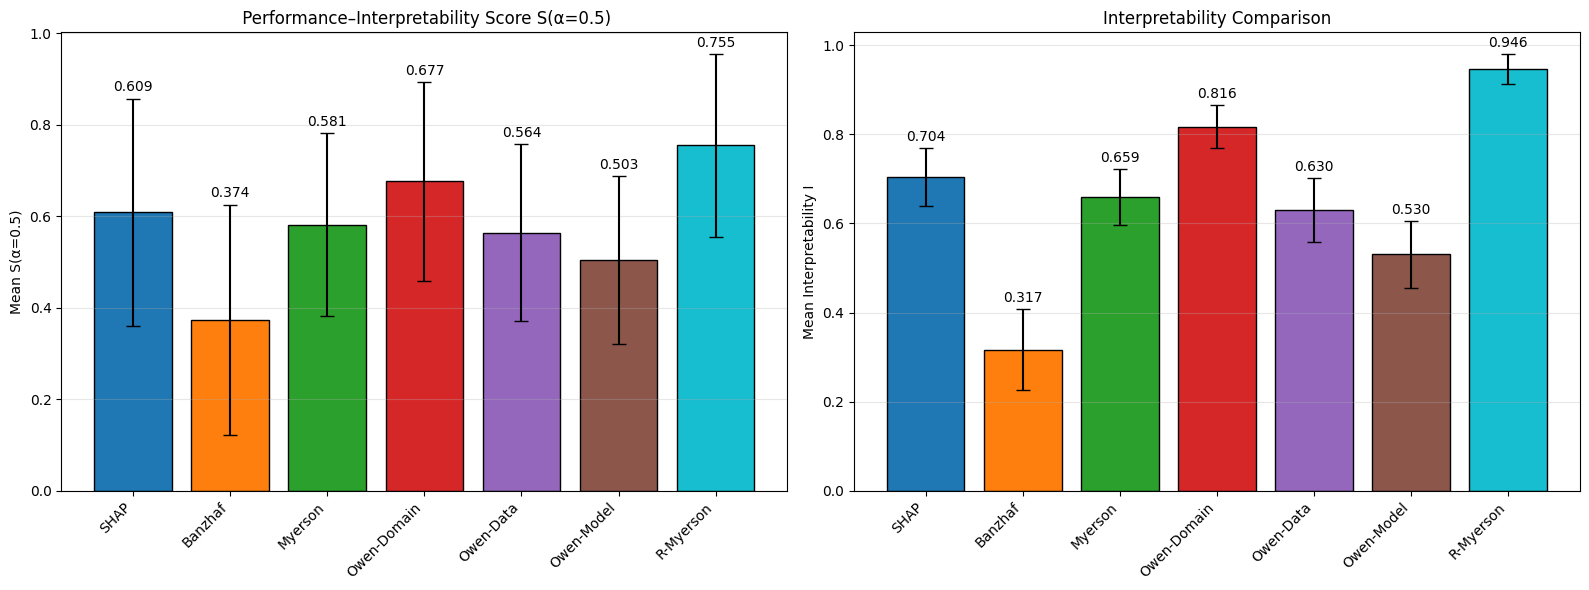

In [41]:

methods = method_order

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ------------------------------------------------------------
# PLOT  – S(α=0.5) by method
# ------------------------------------------------------------
ax = axes[0]
S_means = metrics.groupby("Method")["S(α=0.5)"].mean().reindex(methods)
S_stds  = metrics.groupby("Method")["S(α=0.5)"].std().reindex(methods)

bars = ax.bar(
    S_means.index, S_means.values,
    yerr=S_stds.values,
    color=[method_colors[m] for m in S_means.index],
    edgecolor='black', capsize=5
)

ax.bar_label(bars, fmt="%.3f", padding=3)
ax.set_xticklabels(S_means.index, rotation=45, ha='right')
ax.set_ylabel("Mean S(α=0.5)")
ax.set_title(" Performance–Interpretability Score S(α=0.5)")
ax.grid(axis='y', alpha=0.3)

# ------------------------------------------------------------
# PLOT – Interpretability I by method
# ------------------------------------------------------------
ax = axes[1]
I_means = metrics.groupby("Method")["I"].mean().reindex(methods)
I_stds  = metrics.groupby("Method")["I"].std().reindex(methods)

bars = ax.bar(
    I_means.index, I_means.values,
    yerr=I_stds.values,
    color=[method_colors[m] for m in I_means.index],
    edgecolor='black', capsize=5
)

ax.bar_label(bars, fmt="%.3f", padding=3)
ax.set_xticklabels(I_means.index, rotation=45, ha='right')
ax.set_ylabel("Mean Interpretability I")
ax.set_title("Interpretability Comparison")
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("coursera_plot1_2_side_by_side.png", dpi=150)
plt.show()


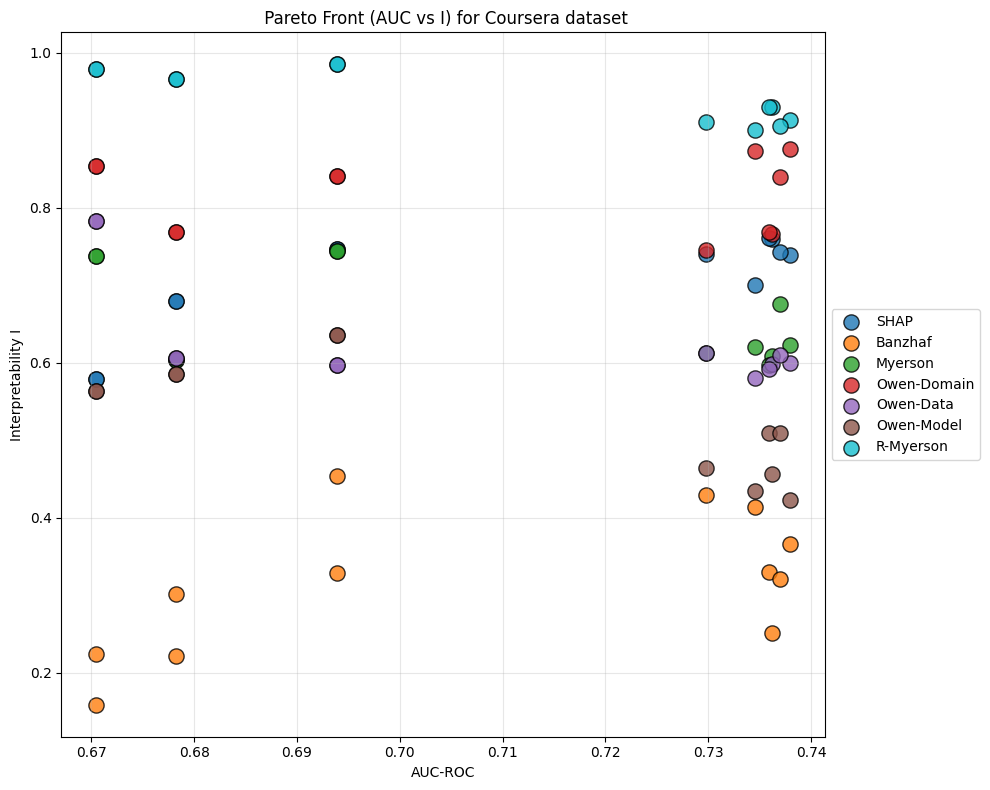

In [42]:
# PLOT  – Pareto front (AUC vs I)
plt.figure(figsize=(10, 8))
for method in methods:
    sub = metrics[metrics['Method'] == method]
    plt.scatter(sub['AUC'], sub['I'],
                s=120, label=method,
                color=method_colors[method],
                alpha=0.8, edgecolors='black')
plt.xlabel("AUC-ROC")
plt.ylabel("Interpretability I")
plt.title(" Pareto Front (AUC vs I) for Coursera dataset")
plt.grid(alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('coursera_plot3_pareto.png', dpi=150)
plt.show()

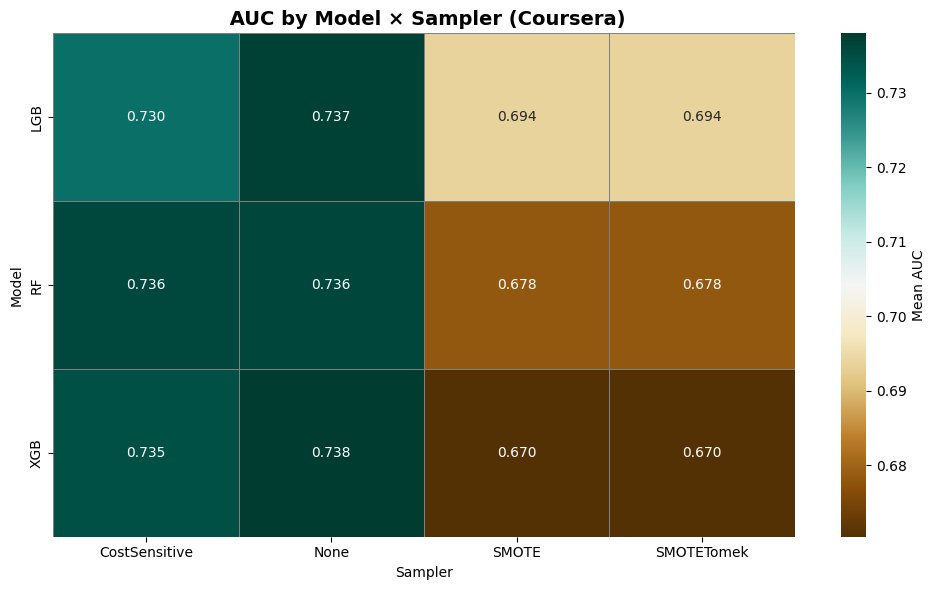

In [61]:
# ============================================================
#AUC by Model × Sampler (HEATMAP VERSION)
# ============================================================

plt.figure(figsize=(10, 6))

# Pivot table (mean AUC)
auc_pivot = metrics.pivot_table(
    values='AUC',
    index='Model',
    columns='Sampler',
    aggfunc='mean'
).fillna(0)

# Heatmap
sns.heatmap(
    auc_pivot,
    annot=True,
    fmt=".3f",
    cmap = "BrBG",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Mean AUC'}
)

plt.title(" AUC by Model × Sampler (Coursera)", fontsize=14, fontweight='bold')
plt.xlabel("Sampler")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig("coursera_plot4_auc_heatmap.png", dpi=150)
plt.show()

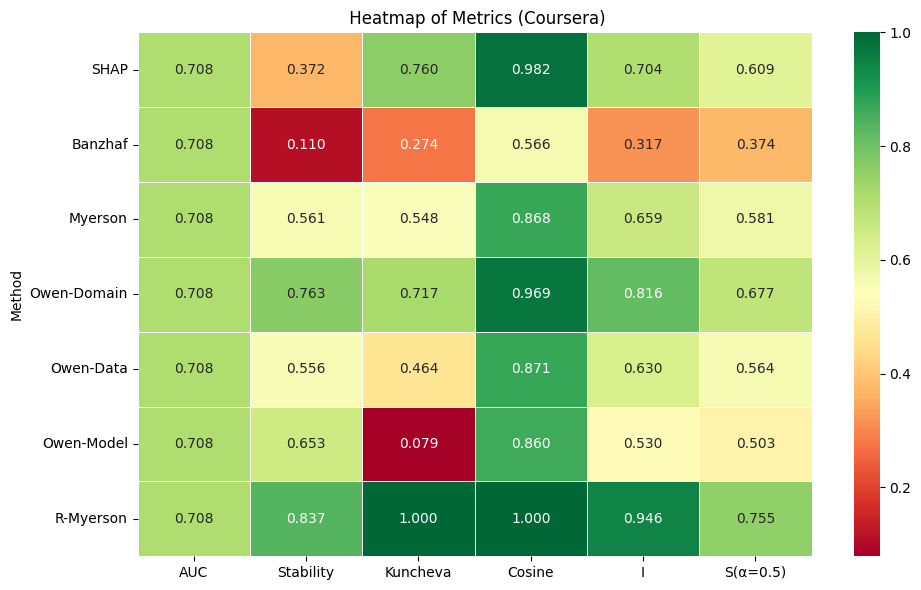

In [22]:
# PLOT 7 – Heatmap of metrics
plt.figure(figsize=(10, 6))
heatmap_data = metrics.groupby("Method")[['AUC', 'Stability', 'Kuncheva', 'Cosine', 'I', 'S(α=0.5)']].mean().reindex(methods)
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', linewidths=0.5)
plt.title(" Heatmap of Metrics (Coursera)")
plt.tight_layout()
plt.savefig('coursera_plot7_heatmap.png', dpi=150)
plt.show()

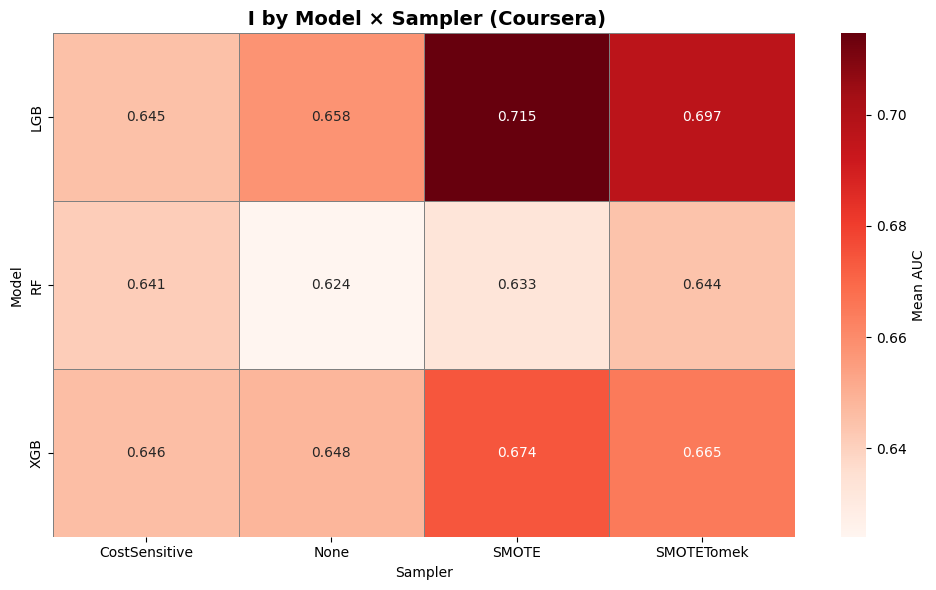

In [34]:
# ============================================================
#AUC by Model × Sampler (HEATMAP VERSION)
# ============================================================

plt.figure(figsize=(10, 6))

# Pivot table (mean I)
auc_pivot = metrics.pivot_table(
    values='I',
    index='Model',
    columns='Sampler',
    aggfunc='mean'
).fillna(0)

# Heatmap
sns.heatmap(
    auc_pivot,
    annot=True,
    fmt=".3f",
    cmap="Reds",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Mean AUC'}
)

plt.title(" I by Model × Sampler (Coursera)", fontsize=14, fontweight='bold')
plt.xlabel("Sampler")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig("coursera_I_heatmap.png", dpi=150)
plt.show()


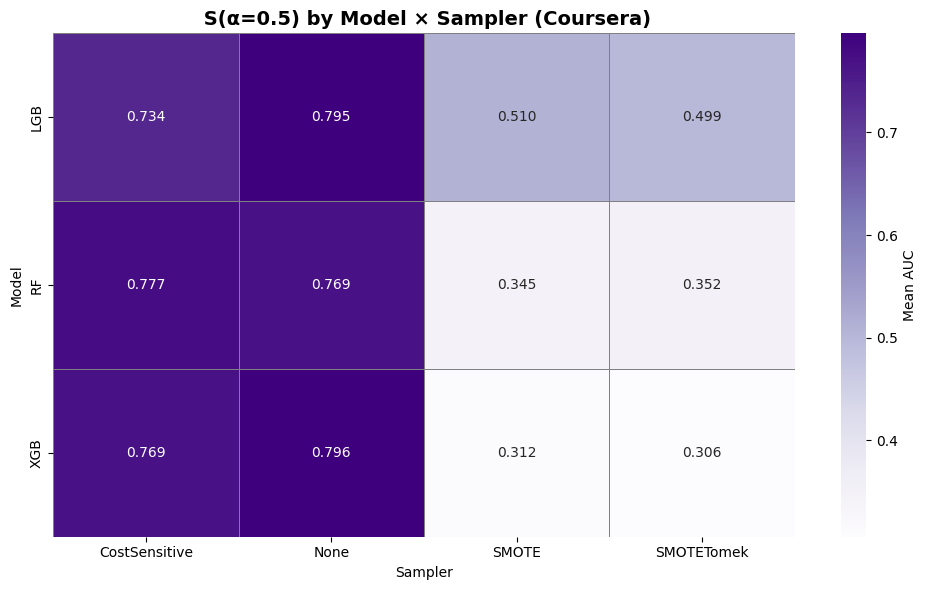

In [51]:
# ============================================================
#S(α=0.5) by Model × Sampler (HEATMAP VERSION)
# ============================================================

plt.figure(figsize=(10, 6))

# Pivot table (mean S(α=0.5))
auc_pivot = metrics.pivot_table(
    values='S(α=0.5)',
    index='Model',
    columns='Sampler',
    aggfunc='mean'
).fillna(0)

# Heatmap
sns.heatmap(
    auc_pivot,
    annot=True,
    fmt=".3f",
    cmap="Purples",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Mean AUC'}
)

plt.title(" S(α=0.5) by Model × Sampler (Coursera)", fontsize=14, fontweight='bold')
plt.xlabel("Sampler")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig("coursera_S_heatmap.png", dpi=150)
plt.show()


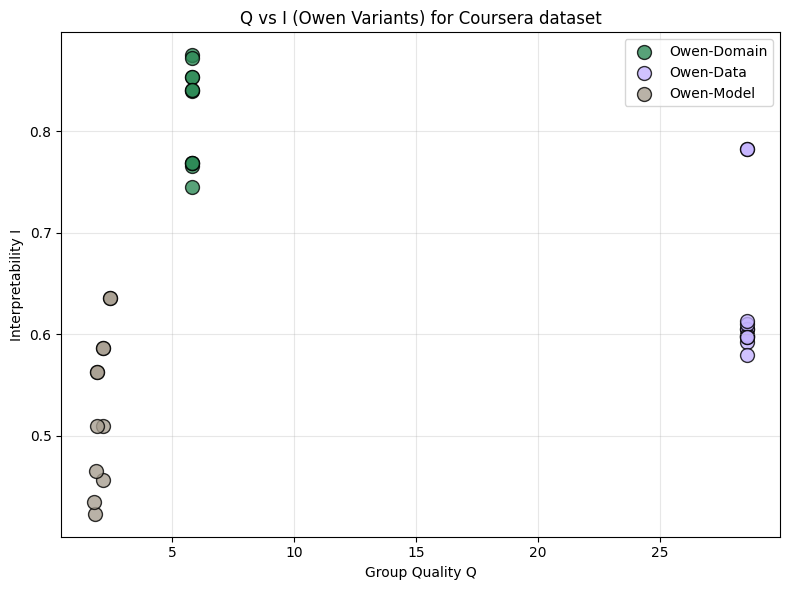

In [24]:
# PLOT  – Q vs I for Owen variants
plt.figure(figsize=(8, 6))
owen_methods = ['Owen-Domain', 'Owen-Data', 'Owen-Model']
Q_means = metrics[metrics['Method'].isin(owen_methods)].groupby('Method')['Q'].mean().reindex(owen_methods)
for method in owen_methods:
    sub = metrics[metrics['Method'] == method]
    plt.scatter(sub['Q'], sub['I'],
                s=100, label=method,
                color=method_colors[method],
                alpha=0.8, edgecolors='black')
plt.xlabel("Group Quality Q")
plt.ylabel("Interpretability I")
plt.title("Q vs I (Owen Variants) for Coursera dataset")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('coursera_plot9_q_vs_i.png', dpi=150)
plt.show()

In [29]:
def compute_global_agreement(all_explanations):
    """
    Computes cosine similarity between mean importance vectors
    of each explainer (global agreement).
    """

    print("\n=== GLOBAL AGREEMENT ACROSS ALL MODELS & SAMPLERS ===")

    method_names = methods
    M = len(method_names)
    G = np.zeros((M, M))

    # Compute mean vectors for each method
    mean_vectors = []
    for method in method_names:
        all_runs = []
        for (mname, sname), method_dict in all_explanations.items():
            all_runs.extend(method_dict[method])
        vec = np.mean([np.abs(e).mean(axis=0) for e in all_runs], axis=0)
        mean_vectors.append(vec)

    # Fill matrix
    for i in range(M):
        for j in range(M):
            G[i, j] = 1 - cosine(mean_vectors[i], mean_vectors[j])

    # Print matrix
    print("\nGlobal Agreement Matrix (cosine similarity):")
    print(pd.DataFrame(G, index=method_names, columns=method_names))

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        G, annot=True, cmap="Blues",
        xticklabels=method_names, yticklabels=method_names,
        fmt=".2f"
    )
    plt.title("Global Agreement Between Explanation Methods")
    plt.tight_layout()
    plt.show()


# ============================================================
# LOCAL AGREEMENT MATRIX (METHOD × METHOD)
# ============================================================

def compute_local_agreement(all_explanations):
    """
    Computes cosine similarity between explanation methods
    on a per-sample basis (local agreement).
    """

    print("\n=== LOCAL AGREEMENT ACROSS ALL MODELS & SAMPLERS ===")

    method_names = methods
    M = len(method_names)
    L = np.zeros((M, M))

    # Collect all runs across models/samplers
    all_runs = []
    for (mname, sname), method_dict in all_explanations.items():
        all_runs.append(method_dict)

    # Compute pairwise local agreement
    for i, mi in enumerate(method_names):
        for j, mj in enumerate(method_names):

            sims = []

            for run in all_runs:
                Ei_list = run[mi]
                Ej_list = run[mj]

                # Pairwise sample-level similarity
                for Ei, Ej in zip(Ei_list, Ej_list):
                    # Ei, Ej: arrays of shape (num_samples, num_features)
                    for vi, vj in zip(Ei, Ej):
                        sims.append(1 - cosine(np.abs(vi), np.abs(vj)))

            L[i, j] = np.mean(sims)

    # Print matrix
    print("\nLocal Agreement Matrix (cosine similarity):")
    print(pd.DataFrame(L, index=method_names, columns=method_names))

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        L, annot=True, cmap="Greens",
        xticklabels=method_names, yticklabels=method_names,
        fmt=".2f"
    )
    plt.title("Local Agreement Between Explanation Methods")
    plt.tight_layout()
    plt.show()


In [37]:
def plot_global_local_agreement(all_explanations):
    method_names = methods
    M = len(method_names)

    # ------------------------------------------------------------
    # GLOBAL AGREEMENT
    # ------------------------------------------------------------
    mean_vectors = []
    for method in method_names:
        all_runs = []
        for (mname, sname), method_dict in all_explanations.items():
            all_runs.extend(method_dict[method])
        vec = np.mean([np.abs(e).mean(axis=0) for e in all_runs], axis=0)
        mean_vectors.append(vec)

    G = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            G[i, j] = 1 - cosine(mean_vectors[i], mean_vectors[j])

    # ------------------------------------------------------------
    # LOCAL AGREEMENT
    # ------------------------------------------------------------
    L = np.zeros((M, M))
    all_runs = [method_dict for (_, _), method_dict in all_explanations.items()]

    for i, mi in enumerate(method_names):
        for j, mj in enumerate(method_names):

            sims = []
            for run in all_runs:
                Ei_list = run[mi]
                Ej_list = run[mj]

                for Ei, Ej in zip(Ei_list, Ej_list):
                    for vi, vj in zip(Ei, Ej):
                        sims.append(1 - cosine(np.abs(vi), np.abs(vj)))

            L[i, j] = np.mean(sims)

    # ------------------------------------------------------------
    # SIDE-BY-SIDE HEATMAPS
    # ------------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(
        G, annot=True, cmap="Blues",
        xticklabels=method_names, yticklabels=method_names,
        fmt=".2f", ax=axes[0]
    )
    axes[0].set_title("Global Agreement Between Explanation Methods")

    sns.heatmap(
        L, annot=True, cmap="Greens",
        xticklabels=method_names, yticklabels=method_names,
        fmt=".2f", ax=axes[1]
    )
    axes[1].set_title("Local Agreement Between Explanation Methods")

    plt.tight_layout()
    plt.show()

    # Print matrices
    print("\nGlobal Agreement Matrix:")
    print(pd.DataFrame(G, index=method_names, columns=method_names))

    print("\nLocal Agreement Matrix:")
    print(pd.DataFrame(L, index=method_names, columns=method_names))


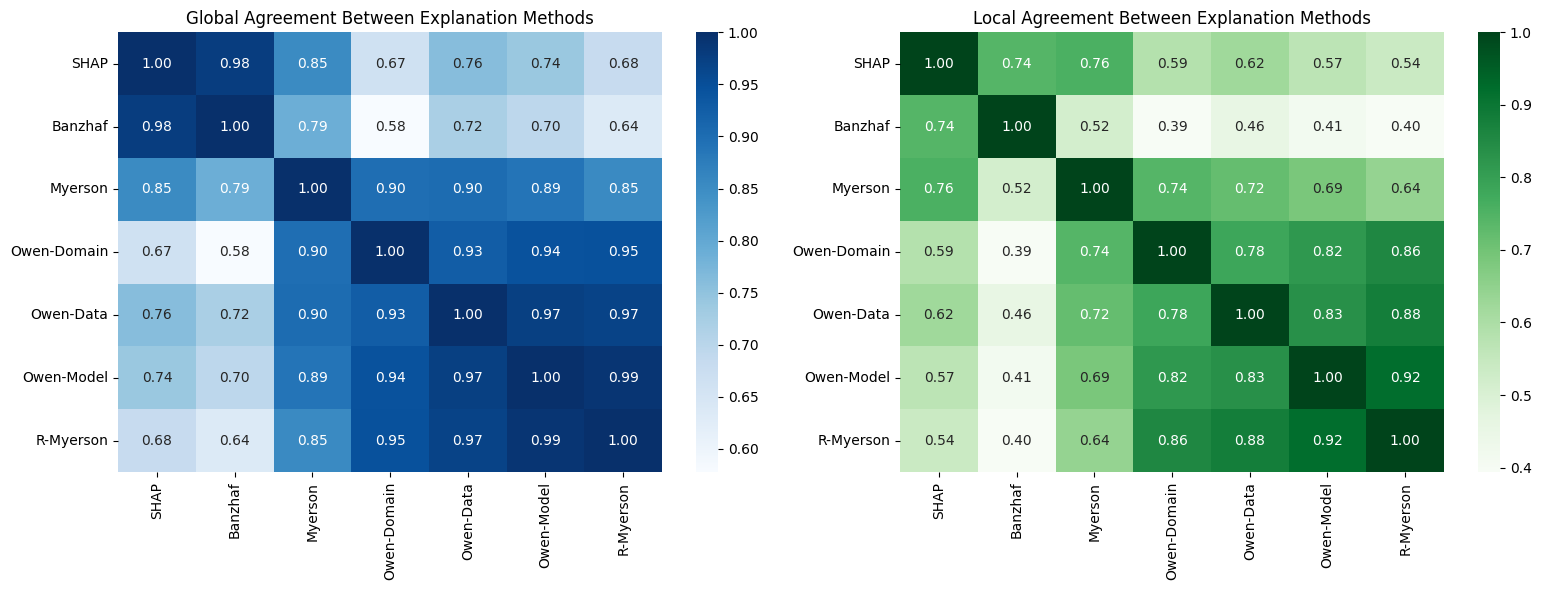


Global Agreement Matrix:
                 SHAP   Banzhaf   Myerson  Owen-Domain  Owen-Data  Owen-Model  \
SHAP         1.000000  0.977194  0.852435     0.665179   0.759865    0.740618   
Banzhaf      0.977194  1.000000  0.788146     0.577957   0.719809    0.695332   
Myerson      0.852435  0.788146  1.000000     0.899232   0.901585    0.888740   
Owen-Domain  0.665179  0.577957  0.899232     1.000000   0.926788    0.944909   
Owen-Data    0.759865  0.719809  0.901585     0.926788   1.000000    0.974458   
Owen-Model   0.740618  0.695332  0.888740     0.944909   0.974458    1.000000   
R-Myerson    0.682707  0.635075  0.854783     0.946145   0.969811    0.990221   

             R-Myerson  
SHAP          0.682707  
Banzhaf       0.635075  
Myerson       0.854783  
Owen-Domain   0.946145  
Owen-Data     0.969811  
Owen-Model    0.990221  
R-Myerson     1.000000  

Local Agreement Matrix:
                 SHAP   Banzhaf   Myerson  Owen-Domain  Owen-Data  Owen-Model  \
SHAP         1.0000

In [39]:
plot_global_local_agreement(all_explanations)


#Statistical analysis

In [33]:
# ============================================================
#  STATISTICAL ANALYSIS (FRIEDMAN, NEMENYI, WILCOXON, CORR)
# ============================================================
!pip install scikit_posthocs -q
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare, wilcoxon, spearmanr, kendalltau
import numpy as np
import pandas as pd

print("\n==================== STATISTICAL ANALYSIS ====================\n")

# Load metrics
results_full = pd.read_csv("coursera_loans_results_7methods.csv")

alpha = 0.05

def tick(p):
    return "✓" if p < alpha else "✗"

def effect_label(delta):
    d_abs = abs(delta)
    if d_abs < 0.147:
        return "negligible"
    elif d_abs < 0.33:
        return "small"
    elif d_abs < 0.474:
        return "medium"
    else:
        return "large"

def cliffs_delta(x, y):
    x = np.array(x)
    y = np.array(y)
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    n1 = len(x)
    n2 = len(y)
    if n1 == 0 or n2 == 0:
        return np.nan
    diffs = x.reshape(-1, 1) - y.reshape(1, -1)
    n_greater = np.sum(diffs > 0)
    n_less = np.sum(diffs < 0)
    return (n_greater - n_less) / (n1 * n2)

# Pivot S(α=0.5)
pivot_T = results_full.pivot_table(
    values='S(α=0.5)',
    index=['Model', 'Sampler'],
    columns='Method'
)

complete_methods = pivot_T.dropna(axis=1).columns.tolist()
print("Methods included:", complete_methods, "\n")

# 1. Friedman test
print("=== Friedman Test ===")
fried_stat, fried_p = friedmanchisquare(
    *[pivot_T[m].values for m in complete_methods]
)
print(f"χ²={fried_stat:.4f}, p={fried_p:.6f} {tick(fried_p)}\n")

# 2. Nemenyi post-hoc
if fried_p < alpha:
    print("=== Nemenyi Post-hoc ===")
    nemenyi_p = sp.posthoc_nemenyi_friedman(pivot_T[complete_methods].values)
    nemenyi_p.index = complete_methods
    nemenyi_p.columns = complete_methods
    print(nemenyi_p)
    nemenyi_p.to_csv("nemenyi_results.csv")
else:
    print("Friedman not significant → skipping Nemenyi.\n")

# 3. Wilcoxon + Cliff's delta
print("\n=== Wilcoxon + Cliff's Delta ===")
rows = []
for i in range(len(complete_methods)):
    for j in range(i + 1, len(complete_methods)):
        m1, m2 = complete_methods[i], complete_methods[j]
        x = pivot_T[m1].values
        y = pivot_T[m2].values
        stat, p = wilcoxon(x, y)
        delta = cliffs_delta(x, y)
        rows.append({
            'Method1': m1,
            'Method2': m2,
            'Wilcoxon_stat': stat,
            'p_value': p,
            'Significant': tick(p),
            "Cliff's_delta": delta,
            'Effect_size': effect_label(delta)
        })

wilcoxon_df = pd.DataFrame(rows)
print(wilcoxon_df)
wilcoxon_df.to_csv("wilcoxon_cliffs_results.csv", index=False)

# 4. Correlation AUC vs I
print("\n=== Correlation AUC vs I ===")
rho_s, p_s = spearmanr(results_full['AUC'], results_full['I'])
tau_k, p_k = kendalltau(results_full['AUC'], results_full['I'])

print(f"Spearman ρ={rho_s:.3f}, p={p_s:.6f} {tick(p_s)}")
print(f"Kendall τ={tau_k:.3f}, p={p_k:.6f} {tick(p_k)}")

pd.DataFrame([{
    'Spearman_rho': rho_s,
    'Spearman_p': p_s,
    'Kendall_tau': tau_k,
    'Kendall_p': p_k
}]).to_csv("auc_I_correlation.csv", index=False)

print("\n✓ Statistical analysis complete.\n")


==================== STATISTICAL ANALYSIS ====================

Methods included: ['Banzhaf', 'Myerson', 'Owen-Data', 'Owen-Domain', 'Owen-Model', 'R-Myerson', 'SHAP'] 

=== Friedman Test ===
χ²=49.7143, p=0.000000 ✓

=== Nemenyi Post-hoc ===
                  Banzhaf   Myerson  Owen-Data  Owen-Domain  Owen-Model  \
Banzhaf      1.000000e+00  0.120280   0.155695     0.000019    0.894364   
Myerson      1.202804e-01  1.000000   1.000000     0.248058    0.792087   
Owen-Data    1.556952e-01  1.000000   1.000000     0.198202    0.847902   
Owen-Domain  1.882676e-05  0.248058   0.198202     1.000000    0.003908   
Owen-Model   8.943641e-01  0.792087   0.847902     0.003908    1.000000   
R-Myerson    7.998651e-08  0.018352   0.012732     0.958006    0.000056   
SHAP         8.708044e-03  0.976584   0.958006     0.792087    0.248058   

                R-Myerson      SHAP  
Banzhaf      7.998651e-08  0.008708  
Myerson      1.835196e-02  0.976584  
Owen-Data    1.273154e-02  0.958006  
Owe